# Advanced Insights: Multi-Latent Attention Architecture

## Key Architectural Innovations

### Compression-Position Decoupling
```python
# Two parallel pathways with different roles:
[b, s, d] -> [b, s, d_c] -> [b, s, d]     # Compression pathway
[b, s, d] -> [b, s, d_r] -> RoPE()        # Position pathway
```
Critical insight: Matrix multiplication non-commutativity necessitates pathway separation for efficient inference.

### Asymmetric Dimensionality
```
Q pathway: per-head rotary dimensions [b, s, n_h, d_r]
K pathway: shared rotary dimensions  [b, s, 1, d_r]
```
Design choice allows computational reuse while maintaining positional awareness.

### Cache Optimization Strategy
Two distinct caches with different roles:
```python
cache_kv: [b, max_len, d_c]    # Compressed KV states
cache_rk: [b, max_len, d_r]    # Shared rotary key
```
Optimization insight: `d_c + d_r << d_model`, enabling significant memory reduction.

## Implementation Subtleties

### Matrix Absorption During Inference
```
Standard: W^Q @ (W^UK @ c^KV)           # Three matrix multiplications
Optimized: (W^Q @ W^UK) @ c^KV          # Two matrix multiplications
```
Key requirement: Position-agnostic main pathway enables matrix pre-multiplication.

### Attention Pattern Evolution
```
t=1: Pattern[1:1]     # Initial token
t=2: Pattern[1:2]     # One previous token
t=n: Pattern[1:n]     # Full context window
```
Cache growth introduces subtle position-dependent patterns requiring careful mask handling.

### Dimension Flow Control
Critical transitions to monitor:
```
[b, s, d] -> [b, s, d_c]              # Down projection
[b, s, d_c] -> [b, s+cache, d_c]      # Cache concatenation
[b, s+cache, d_c] -> [b, s+cache, d]  # Up projection
```
Each transition must preserve both positional and content information.

## Edge Cases and Considerations

### Cross-Attention Scenarios
```python
q_len != kv_len  # Length mismatch
d_c < d_model    # Compression bottleneck
```
Compression and position information must be maintained across different sequence lengths.

### Position-Aware Cache Updates
```python
# Position-dependent attention mask creation
mask[:, :, i, :(start_pos + i + 1)] = 0       # Can attend
mask[:, :, i, (start_pos + i + 1):] = -inf    # Cannot attend
```
Mask must evolve with cache to maintain causal attention patterns.

### Numerical Stability
1. Scaling factor accounts for both pathways: `1/sqrt(d_head + d_rotate)`
2. Compression dimensions balance between efficiency and representation capacity
3. RoPE dimensions impact position encoding granularity

## Performance Implications

### Memory Complexity
```
Standard: O(b * s * d_model)
MLA:      O(b * s * (d_c + d_r))
```
Where `d_c + d_r << d_model`

### Computational Trade-offs
1. Additional projections for position pathway
2. Reduced cache size enables longer sequences
3. Matrix absorption reduces inference compute

## Integration Considerations

### Initialization Strategy
```python
# Critical hyperparameters
d_c:      Compression dimension
d_rotate: Position encoding dimension
```
Trade-off between compression efficiency and position encoding capacity.

### Cache Management
```python
# Two update patterns
cache_kv[:, pos:pos+s] = current_kv    # Content cache
cache_rk[:, pos:pos+s] = current_rk    # Position cache
```
Synchronization between caches crucial for correctness.

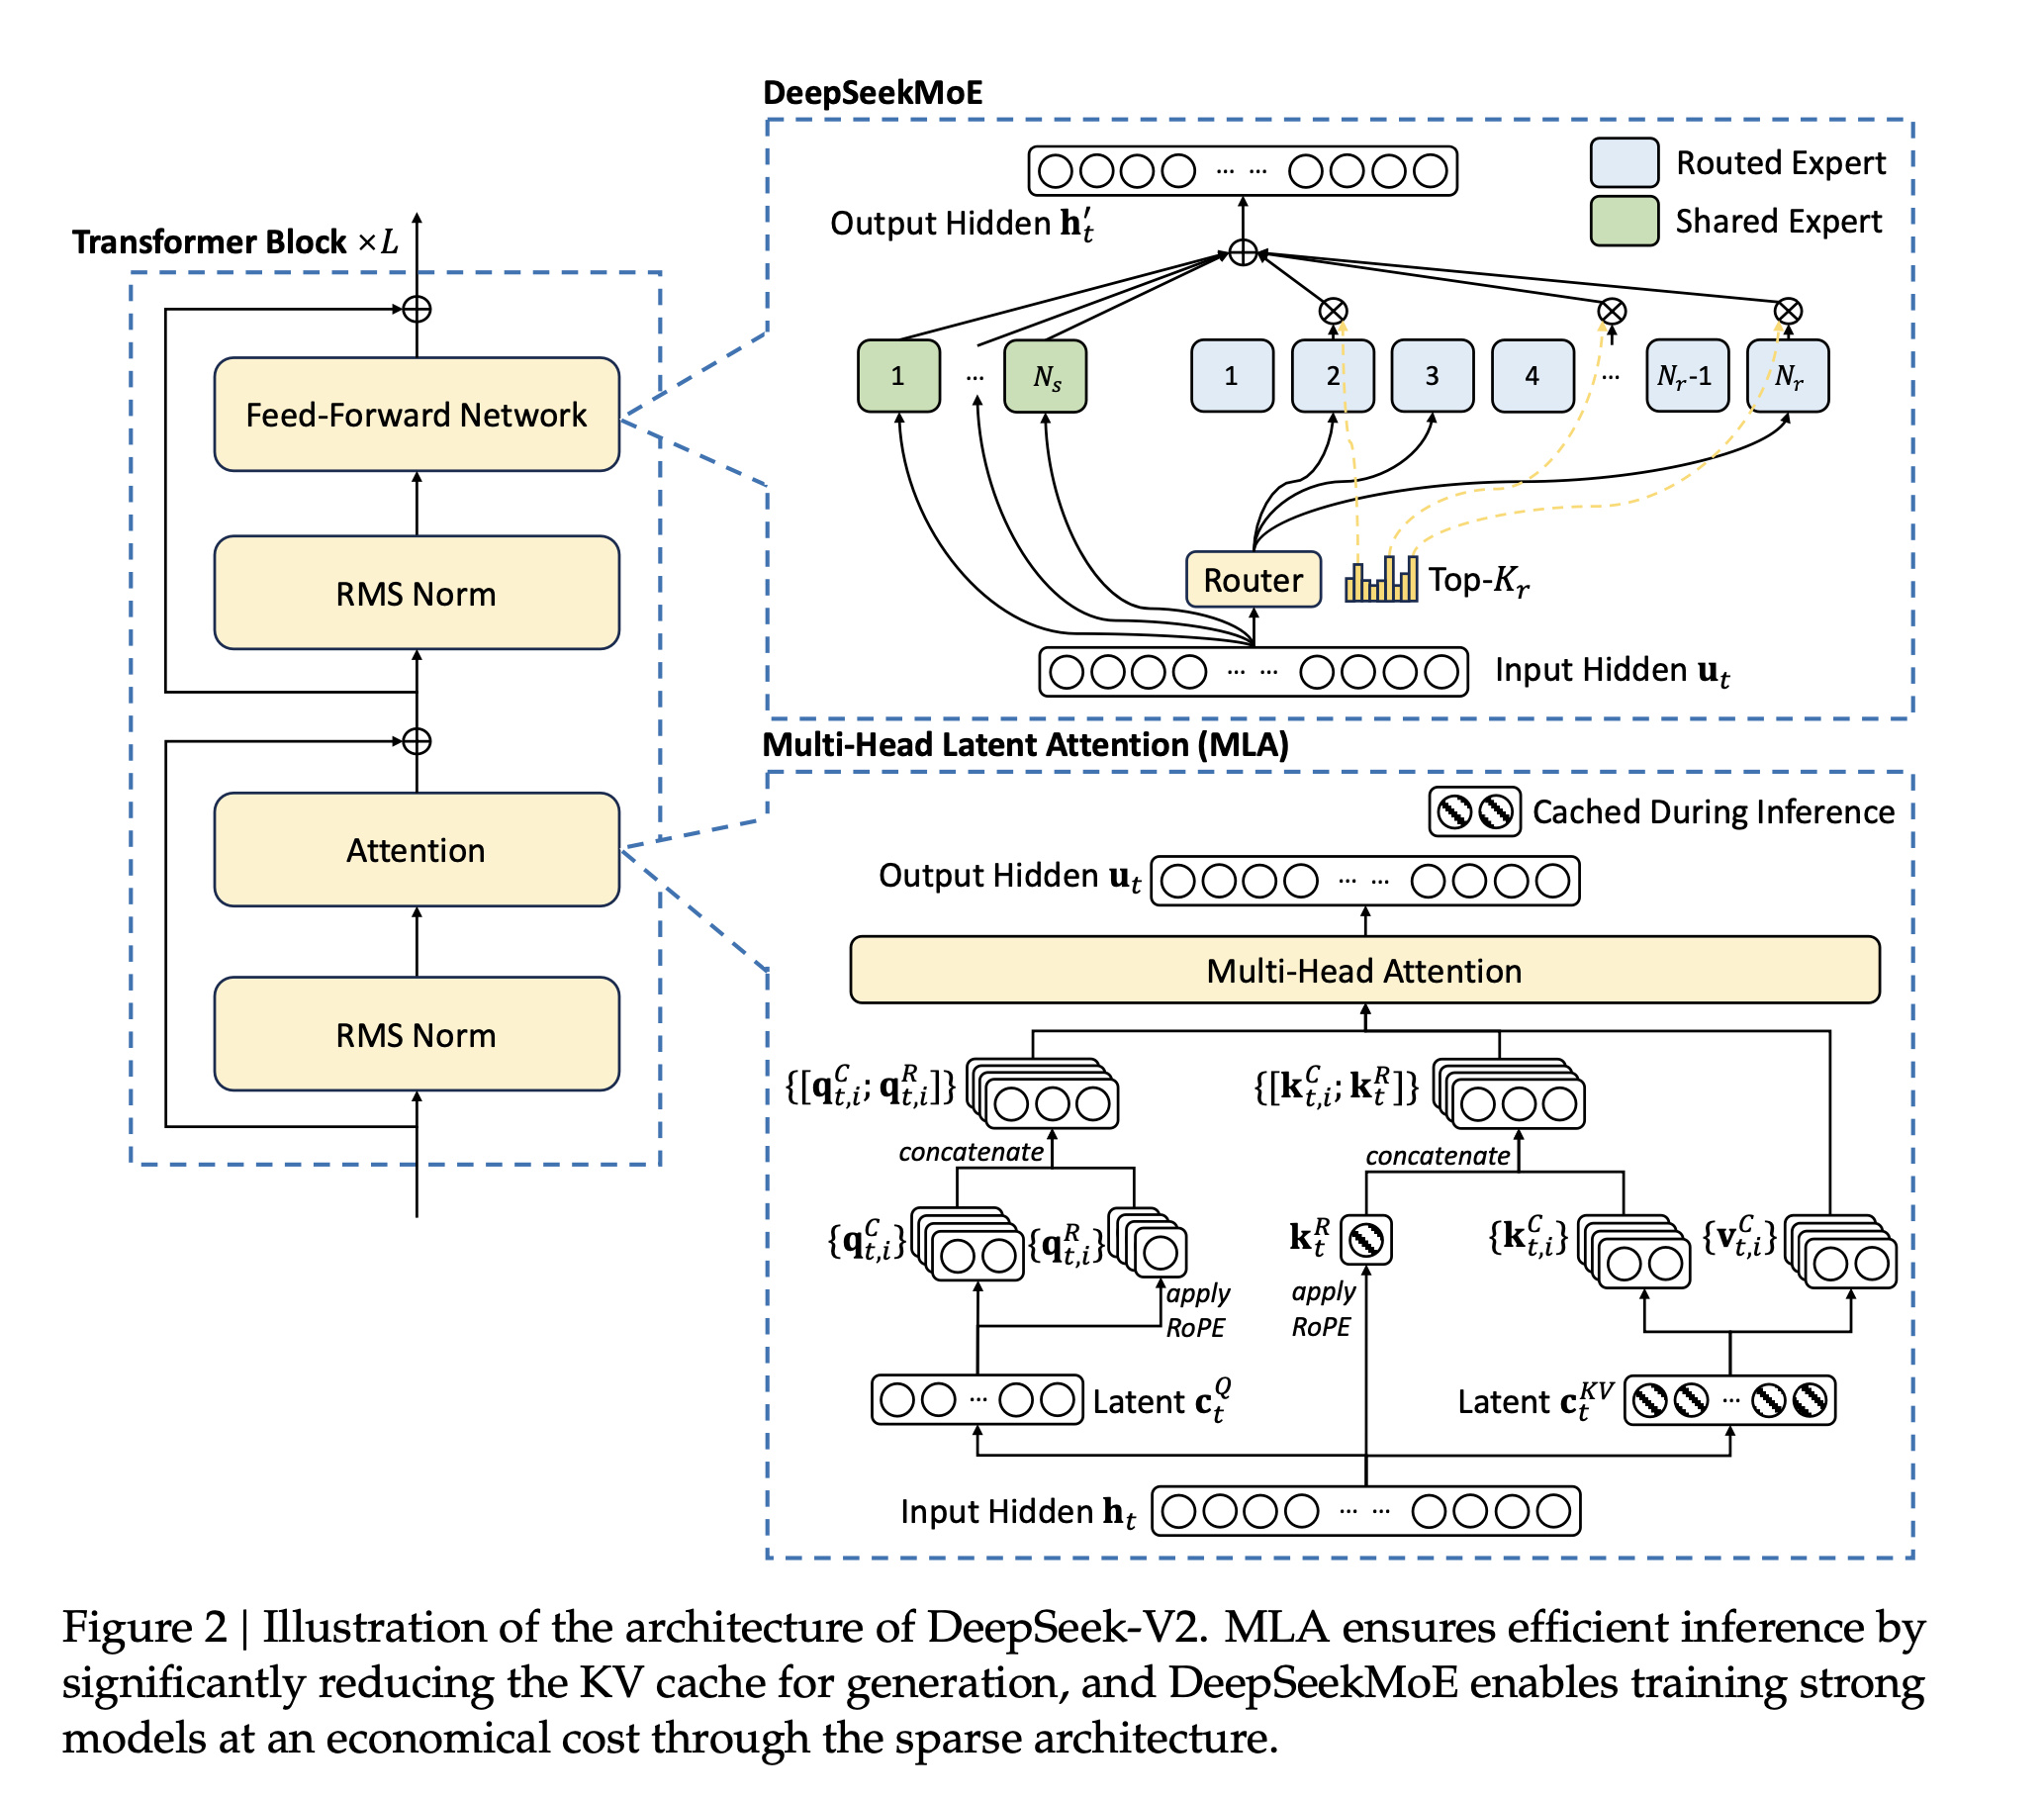

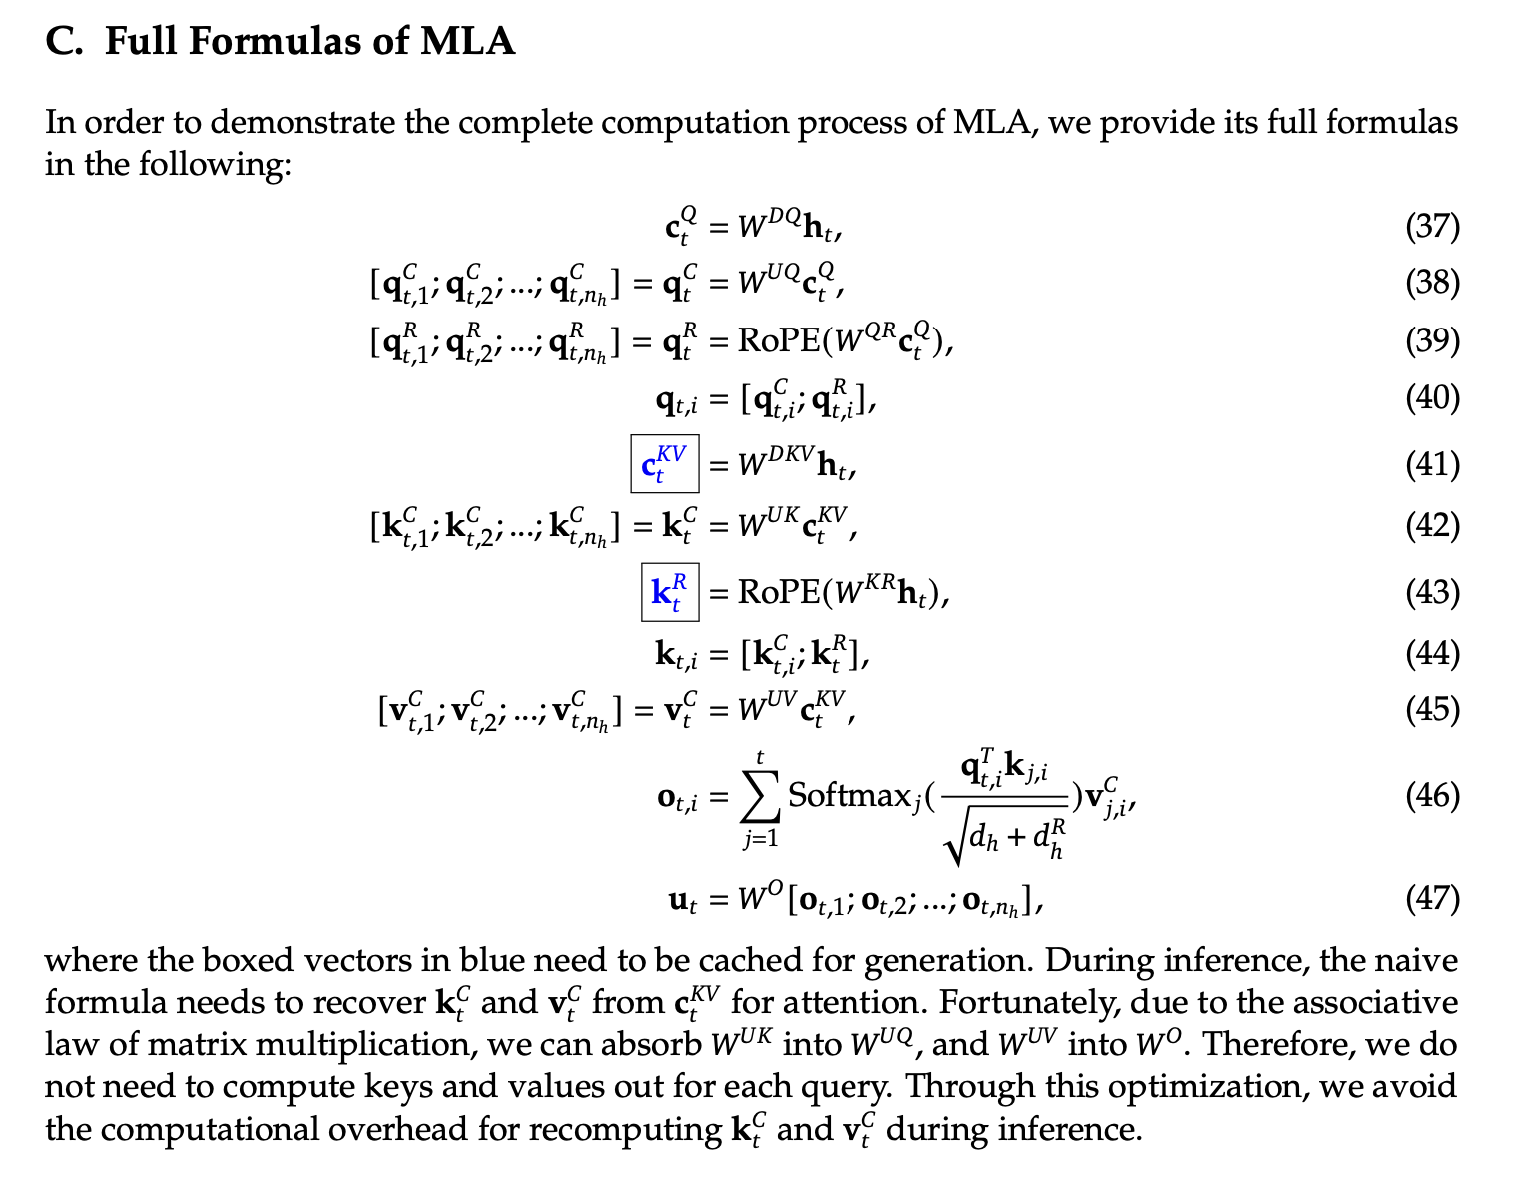

# Advanced Insights: Attention Masks with KV-Caching

## Key Pitfalls in Complex Attention Implementations

### Dimension Evolution with Caching
```python
# Crucial dimension transitions in cached attention:
[b, s, d_model] -> [b, s+cache, d_c] -> [b, s+cache, d_model] -> [b, num_h, s, d_head]
```
The non-obvious trap: even with growing K/V cache, attention output dimensions must match query length, not cached length.

### Mask Causality with Growing Cache
Standard causal masks break with KV-caching - they don't account for position-dependent attention patterns across cached sequences. Critical edge cases:
- Token at position `i` must attend to `[0:start_pos+i]`
- Naive mask extension leads to incorrect causality preservation
- Performance impact of position-wise mask generation

### Optimization Considerations
1. Memory vs Compute tradeoff: Precomputing extended masks vs generating per position
2. Batch dimension handling: Mask broadcasting impacts memory usage
3. Fused attention patterns may break with custom mask handling

## Debugging Strategy for Non-Obvious Cases
Monitor these dimension transitions for subtle bugs:
```python
C_KV.shape      # Should grow: [b, s₁, d_c] -> [b, s₁+s₂, d_c]
K_state.shape   # Post-projection growth affects attention patterns
att_output.shape # Must maintain query dimensions despite K/V growth
```

## Practical Example: DeepSeek's MLA Edge Case
In Multi-Latent Attention, the compressed KV cache introduces subtle interactions with attention masks due to:
1. Joint compression affecting position-dependent patterns
2. Non-standard dimension flow through compression/decompression
3. Mask causality preservation across cached compressed states

# MLA Implementation

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple

import math



def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Validate input dimensions
    assert xq.shape[-1] == xk.shape[-1], "Query and Key must have same embedding dimension"
    assert xq.shape[-1] % 2 == 0, "Embedding dimension must be even"

    # Get sequence lengths
    q_len = xq.shape[1]
    k_len = xk.shape[1]
    
    # Use appropriate part of freqs_cis for each sequence
    q_freqs = freqs_cis[:q_len]
    k_freqs = freqs_cis[:k_len]
    
    # Apply rotary embeddings separately
    # split last dimention to [xq.shape[:-1]/2, 2]
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
 
    # Reshape freqs for each
    q_freqs = reshape_for_broadcast(q_freqs, xq_)
    k_freqs = reshape_for_broadcast(k_freqs, xk_)
    
    # Works for both [bsz, seqlen, n_heads*head_dim] and [bsz, seqlen, n_heads, head_dim]
    xq_out = torch.view_as_real(xq_ * q_freqs).flatten(xq.ndim-1) 
    xk_out = torch.view_as_real(xk_ * k_freqs).flatten(xk.ndim-1)

    return xq_out.type_as(xq), xk_out.type_as(xk)




class MultiLatentAttention(nn.Module):
    """
        Multi-Head Latent Attention(MLA) Module As in DeepSeek_V2 pape
        Key innovation from standard MHA:
             1. Low-Rank Key-Value Joint Compression 
             2. Decoupled Rotary Position Embedding
             
    Args:
        d_model:  Total dimension of the model.
        num_head: Number of attention heads.
        d_embed:  Embedding dimension
        d_c:      K/V compression dimension
        d_c1:     Q compression dimension
        d_rotate: Dimension for Rotary Position Embedding
        dropout:  Dropout rate for attention scores.
        bias:     Whether to include bias in linear projections.

        d_head:   Inferred from d_model//num_head

    Inputs:
        sequence: input sequence for self-attention and the query for cross-attention
        key_value_state: input for the key, values for cross-attention
    """
    def __init__(
        self, 
        d_model,             # Infer d_head from d_model
        num_head, 
        d_embed, 
        d_c, 
        d_c1, 
        d_rotate, 
        dropout=0.1, 
        bias=True,
        max_batch_size=32,   # For KV cache sizing
        max_seq_len=2048     # For KV cache sizing 
        ):
        super().__init__()
        
        assert d_model % num_head == 0, "d_model must be divisible by num_head"
        assert d_c < d_embed, "Compression dim should be smaller than embedding dim"
        assert d_c1 < d_embed, "Query compression dim should be smaller than embedding dim"
        
        self.d_model = d_model
        self.num_head = num_head
        # Verify dimensions match up
        assert d_model % num_head == 0, f"d_model ({d_model}) must be divisible by num_head ({num_head})"
        self.d_head=d_model//num_head
        self.d_embed = d_embed
        self.d_c = d_c
        self.d_c1 = d_c1
        self.d_rotate = d_rotate
        self.dropout_rate = dropout  # Store dropout rate separately

        # Linear down-projection(compression) transformations
        self.DKV_proj = nn.Linear(d_embed, d_c, bias=bias)
        self.DQ_proj = nn.Linear(d_embed, d_c1, bias=bias)
        
        # linear up-projection transformations
        self.UQ_proj = nn.Linear(d_c1, d_model, bias=bias)
        self.UK_proj = nn.Linear(d_c, d_model, bias=bias)
        self.UV_proj = nn.Linear(d_c, d_model, bias=bias)

        # Linear RoPE-projection
        self.RQ_proj = nn.Linear(d_c1, num_head*d_rotate, bias=bias)
        self.RK_proj = nn.Linear(d_embed, d_rotate, bias=bias)
        
        # linear output transformations
        self.output_proj = nn.Linear( d_model, d_model, bias=bias)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout)

        # Initiialize scaler
        self.scaler = float(1.0 / math.sqrt(self.d_head + d_rotate)) # Store as float in initialization

        # Initialize C_KV and R_K cache for inference
        self.cache_kv = torch.zeros(
            (max_batch_size, max_seq_len, d_c)
        )
        self.cache_rk = torch.zeros(
            (max_batch_size, max_seq_len, d_rotate)
        )

        # Initialize freqs_cis for RoPE
        self.freqs_cis = precompute_freqs_cis(
            d_rotate, max_seq_len * 2
        )
    

    def forward(
        self, 
        sequence, 
        key_value_states = None, 
        att_mask=None,
        use_cache=False,
        start_pos: int = 0
    ):

        """
        Forward pass supporting both standard attention and cached inference
        Input shape: [batch_size, seq_len, d_model=num_head * d_head]
        Args:
            sequence: Input sequence [batch_size, seq_len, d_model]
            key_value_states: Optional states for cross-attention
            att_mask: Optional attention mask
            use_cache: Whether to use KV caching (for inference)
            start_pos: Position in sequence when using KV cache
        """
        batch_size, seq_len, model_dim = sequence.size()
        # prepare for RoPE
        self.freqs_cis = self.freqs_cis.to(sequence.device)
        freqs_cis = self.freqs_cis[start_pos : ]

        # Check only critical input dimensions
        assert model_dim == self.d_model, f"Input dimension {model_dim} doesn't match model dimension {self.d_model}"
        if key_value_states is not None:
            assert key_value_states.size(-1) == self.d_model, \
            f"Cross attention key/value dimension {key_value_states.size(-1)} doesn't match model dimension {self.d_model}"

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        # Determine kv_seq_len early
        kv_seq_len = key_value_states.size(1) if is_cross_attention else seq_len
        
        # Linear projections and reshape for multi-head, in the order of Q, K/V
        # Down and up projection for query
        C_Q = self.DQ_proj(sequence)     #[batch_size, seq_len, d_c1]
        Q_state = self.UQ_proj(C_Q)      #[batch_size, seq_len, d_model]
        # Linear projection for query RoPE pathway
        Q_rotate = self.RQ_proj(C_Q)      #[batch_size, seq_len, num_head*d_rotate]


        if use_cache:
            #Equation (41) in DeepSeek-v2 paper: cache c^{KV}_t
            self.cache_kv = self.cache_kv.to(sequence.device)

            # Get current compressed KV states
            current_kv = self.DKV_proj(key_value_states if is_cross_attention else sequence) #[batch_size, kv_seq_len, d_c]
            # Update cache using kv_seq_len instead of seq_len
            self.cache_kv[:batch_size, start_pos:start_pos + kv_seq_len] = current_kv
            # Use cached compressed KV up to current position
            C_KV = self.cache_kv[:batch_size, :start_pos + kv_seq_len]

            #Equation (43) in DeepSeek-v2 paper: cache the RoPE pathwway for shared key k^R_t
            assert self.cache_rk.size(-1) == self.d_rotate, "RoPE cache dimension mismatch"
            self.cache_rk = self.cache_rk.to(sequence.device)
            # Get current RoPE key
            current_K_rotate = self.RK_proj(key_value_states if is_cross_attention else sequence) #[batch_size, kv_seq_len, d_rotate]
            # Update cache using kv_seq_len instead of seq_len
            self.cache_rk[:batch_size, start_pos:start_pos + kv_seq_len] = current_K_rotate
            # Use cached RoPE key up to current position
            K_rotate = self.cache_rk[:batch_size, :start_pos + kv_seq_len] #[batch_size, cached_len, d_rotate]
            
            
            """handling attention mask"""
            if att_mask is not None:
                # Get the original mask shape
                mask_size = att_mask.size(-1)
                cached_len = start_pos + kv_seq_len        # cached key_len, including previous key
                assert C_KV.size(1) == cached_len, \
            f"Cached key/value length {C_KV.size(1)} doesn't match theoretical length {cached_len}"
                
                # Create new mask matching attention matrix shape
                extended_mask = torch.zeros(
                    (batch_size, 1, seq_len, cached_len),  # [batch, head, query_len, key_len]
                    device=att_mask.device,
                    dtype=att_mask.dtype
                )
                
                # Fill in the mask appropriately - we need to be careful about the causality here
                # For each query position, it should only attend to cached positions up to that point
                for i in range(seq_len):
                    extended_mask[:, :, i, :(start_pos + i + 1)] = 0  # Can attend
                    extended_mask[:, :, i, (start_pos + i + 1):] = float('-inf')  # Cannot attend
                    
                att_mask = extended_mask
        else:
            # Compression projection for C_KV
            C_KV = self.DKV_proj(key_value_states if is_cross_attention else sequence) #[batch_size, kv_seq_len, d_c]\
            # RoPE pathway for *shared* key
            K_rotate = self.RK_proj(key_value_states if is_cross_attention else sequence)
            

        # Up projection for key and value
        K_state = self.UK_proj(C_KV)               #[batch_size, kv_seq_len/cached_len, d_model]
        V_state = self.UV_proj(C_KV)               #[batch_size, kv_seq_len/cached_len, d_model]

        
        Q_state = Q_state.view(batch_size, seq_len, self.num_head, self.d_head)

        # After getting K_state from projection, get its actual sequence length
        actual_kv_len = K_state.size(1)    # kv_seq_len or start_pos + kv_seq_len
        # in cross-attention, key/value sequence length might be different from query sequence length
        # Use actual_kv_len instead of kv_seq_len for reshaping
        K_state = K_state.view(batch_size, actual_kv_len, self.num_head, self.d_head) 
        V_state = V_state.view(batch_size, actual_kv_len, self.num_head, self.d_head)


        #Apply RoPE to query and shared key
        Q_rotate = Q_rotate.view(batch_size, seq_len, self.num_head, self.d_rotate)
        K_rotate = K_rotate.unsqueeze(2).expand(-1, -1, self.num_head, -1)  # [batch, cached_len, num_head, d_rotate]
        Q_rotate, K_rotate = apply_rotary_emb(Q_rotate, K_rotate, freqs_cis=freqs_cis)


        # Concatenate along head dimension
        Q_state = torch.cat([Q_state, Q_rotate], dim=-1)  # [batch_size, seq_len, num_head, d_head + d_rotate]
        K_state = torch.cat([K_state, K_rotate], dim=-1)  # [batch_size, actual_kv_len, num_head, d_head + d_rotate]


        # Scale Q by 1/sqrt(d_k)
        Q_state = Q_state * self.scaler
        Q_state = Q_state.transpose(1, 2)  # [batch_size, num_head, seq_len, head_dim]
        K_state = K_state.transpose(1, 2)  # [batch_size, num_head, actual_kv_len, head_dim]
        V_state = V_state.transpose(1, 2)  # [batch_size, num_head, actual_kv_len, head_dim]

    
        # Compute attention matrix: QK^T
        self.att_matrix = torch.matmul(Q_state, K_state.transpose(-1,-2)) 
    
        # apply attention mask to attention matrix
        if att_mask is not None and not isinstance(att_mask, torch.Tensor):
            raise TypeError("att_mask must be a torch.Tensor")

        if att_mask is not None:
            self.att_matrix = self.att_matrix + att_mask
        
        # apply softmax to the last dimension to get the attention score: softmax(QK^T)
        att_score = F.softmax(self.att_matrix, dim = -1)
    
        # apply drop out to attention score
        att_score = self.dropout(att_score)
    
        # get final output: softmax(QK^T)V
        att_output = torch.matmul(att_score, V_state)
        assert att_output.size(0) == batch_size, "Batch size mismatch"
        assert att_output.size(2) == seq_len, "Output sequence length should match query sequence length"
        
            
        # concatinate all attention heads
        att_output = att_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.num_head*self.d_head) 


        # final linear transformation to the concatenated output
        att_output = self.output_proj(att_output)

        assert att_output.size() == (batch_size, seq_len, self.d_model), \
        f"Final output shape {att_output.size()} incorrect"

        return att_output

# Testing

In [7]:
import torch
import unittest


class TestMultiLatentAttention(unittest.TestCase):
    def setUp(self):
        # Common dimensions for testing
        self.d_model = 512
        self.num_head = 8
        self.d_embed = 512
        self.d_c = 64  # Compression dim for K/V
        self.d_c1 = 64  # Compression dim for Q
        self.d_rotate = 32  # For future RoPE implementation
        self.batch_size = 2
        self.seq_len = 10
        
        # Initialize MLA
        self.mla = MultiLatentAttention(
            d_model=self.d_model,
            num_head=self.num_head,
            d_embed=self.d_embed,
            d_c=self.d_c,
            d_c1=self.d_c1,
            d_rotate=self.d_rotate
        )
        
    def test_basic_forward(self):
        """Test basic forward pass without caching"""
        x = torch.randn(self.batch_size, self.seq_len, self.d_model)
        output = self.mla(x)
        
        # Check output shape
        self.assertEqual(
            output.shape, 
            (self.batch_size, self.seq_len, self.d_model),
            "Output shape mismatch"
        )
        
    def test_cross_attention(self):
        """Test cross-attention functionality"""
        query = torch.randn(self.batch_size, self.seq_len, self.d_model)
        kv = torch.randn(self.batch_size, self.seq_len * 2, self.d_model)  # Different seq_len
        
        output = self.mla(query, key_value_states=kv)
        self.assertEqual(
            output.shape, 
            (self.batch_size, self.seq_len, self.d_model),
            "Cross-attention output shape mismatch"
        )
        
    def test_cache_initialization(self):
        """Test if cache is properly initialized"""
        x = torch.randn(self.batch_size, self.seq_len, self.d_model)
        _ = self.mla(x, use_cache=True, start_pos=0)
        
        self.assertIsNotNone(self.mla.cache_kv)
        self.assertEqual(
            self.mla.cache_kv.shape[-1],
            self.d_c,
            "Cache compression dimension mismatch"
        )
        
    def test_sequential_caching(self):
        """Test sequential forward passes with caching"""
        # Initial sequence
        prompt_len = 5
        prompt = torch.randn(self.batch_size, prompt_len, self.d_model)
        
        # First forward pass with prompt
        output1 = self.mla(prompt, use_cache=True, start_pos=0)
        cached_kv_1 = self.mla.cache_kv[:, :prompt_len].clone()
        
        # Second forward pass with one new token
        new_token = torch.randn(self.batch_size, 1, self.d_model)
        output2 = self.mla(new_token, use_cache=True, start_pos=prompt_len)
        
        # Verify cache consistency
        # First part of cache should remain unchanged
        self.assertTrue(
            torch.allclose(
                self.mla.cache_kv[:, :prompt_len],
                cached_kv_1,
                rtol=1e-5
            ),
            "Cache was modified for previously processed tokens"
        )
        
        # Verify new token was added to cache
        self.assertFalse(
            torch.allclose(
                self.mla.cache_kv[:, prompt_len:prompt_len+1],
                torch.zeros_like(self.mla.cache_kv[:, prompt_len:prompt_len+1]),
                rtol=1e-5
            ),
            "New token was not added to cache"
        )
        
    def test_attention_mask_with_cache(self):
        """Test attention masking with cached KV"""
        seq_len = 5
        x = torch.randn(self.batch_size, seq_len, self.d_model)
        
        # Create causal mask
        mask = torch.triu(
            torch.ones(seq_len, seq_len) * float('-inf'), 
            diagonal=1
        ).unsqueeze(0)
        
        # First forward pass with mask
        output1 = self.mla(x, use_cache=True, start_pos=0, att_mask=mask)
        
        # Second pass with one token
        new_token = torch.randn(self.batch_size, 1, self.d_model)
        extended_mask = torch.triu(
            torch.ones(seq_len + 1, seq_len + 1) * float('-inf'),
            diagonal=1
        ).unsqueeze(0)
        
        output2 = self.mla(
            new_token,
            use_cache=True,
            start_pos=seq_len,
            att_mask=extended_mask
        )
        
        self.assertEqual(
            output2.shape,
            (self.batch_size, 1, self.d_model),
            "Output shape incorrect for cached attention with mask"
        )

def run_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestMultiLatentAttention)
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(suite)

# Run the tests
run_tests()

test_attention_mask_with_cache (__main__.TestMultiLatentAttention.test_attention_mask_with_cache)
Test attention masking with cached KV ... ok
test_basic_forward (__main__.TestMultiLatentAttention.test_basic_forward)
Test basic forward pass without caching ... ok
test_cache_initialization (__main__.TestMultiLatentAttention.test_cache_initialization)
Test if cache is properly initialized ... ok
test_cross_attention (__main__.TestMultiLatentAttention.test_cross_attention)
Test cross-attention functionality ... ok
test_sequential_caching (__main__.TestMultiLatentAttention.test_sequential_caching)
Test sequential forward passes with caching ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.146s

OK


# Appendix --  Understanding and Debugging Attention Masks with KV-Caching

This guide explores the intricate relationship between attention masks and KV-caching in transformer architectures, with a focus on debugging complex dimension mismatches. We'll use the implementation of DeepSeek's Multi-Latent Attention as a case study.

## The Challenge

When implementing attention mechanisms with caching, three key components interact in non-obvious ways:

1. Query/Key/Value dimensions
2. Cached states
3. Attention masks

The main challenge arises because these components have different dimensional requirements at different stages of processing.

## Common Pitfalls

### 1. Mismatched Sequence Lengths

A frequent source of bugs is the mismatch between:
- Query sequence length (new tokens only)
- Key/Value sequence length (cached tokens + new tokens)
- Attention mask dimensions

Consider this error pattern:
```python
RuntimeError: The expanded size of the tensor (1) must match the existing size (6) 
at non-singleton dimension 1. Target sizes: [1, 1, 6]. Tensor sizes: [6, 6]
```

This typically indicates that your attention mask isn't accounting for the cached sequence length.

### 2. Dimension Flow in Cached Attention

Let's track dimensions through a typical forward pass with caching:

```python
# Initial sequence (batch=2, seq_len=5):
C_KV shape: [2, 5, 64]          # Compressed KV
K_state: [2, 5, 512]            # After up-projection
att_output: [2, 5, 512]         # Final output

# Cached generation (new_seq_len=1, start_pos=5):
C_KV shape: [2, 6, 64]          # Previous 5 + new token
K_state: [2, 6, 512]            # Full sequence up-projected
att_output: [2, 1, 512]         # Output only for new token
```

Key insight: While K/V states grow with caching, the output dimension should match only the new query tokens.

## Debugging Strategy

### 1. Verify Mask Dimensions

When using caching, your attention mask needs to:
- Match the attention matrix dimensions `[batch, heads, query_len, key_len]`
- Account for all cached tokens
- Maintain proper causality (each position only attends to itself and previous positions)

### 2. Critical Checkpoints for Debugging

Add dimension checks at these key points:

```python
# 1. After retrieving cached states
print(f"Cache shape: {self.cache_kv.shape}")
print(f"Current token sequence length: {kv_seq_len}")

# 2. After up-projection
print(f"K_state shape after projection: {K_state.shape}")
print(f"Expected reshape: {[batch_size, kv_seq_len, num_head, d_head]}")

# 3. Before output projection
print(f"att_output shape before proj: {att_output.shape}")
```

### 3. Mask Handling Solution

Here's a robust approach to handle attention masks with caching:

```python
if use_cache:
    if att_mask is not None:
        cached_len = start_pos + kv_seq_len
        # Create mask matching attention matrix shape
        extended_mask = torch.zeros(
            (batch_size, 1, seq_len, cached_len),
            device=att_mask.device,
            dtype=att_mask.dtype
        )
        
        # Handle causality for each query position
        for i in range(seq_len):
            extended_mask[:, :, i, :(start_pos + i + 1)] = 0  # Can attend
            extended_mask[:, :, i, (start_pos + i + 1):] = float('-inf')  # Cannot attend
            
        att_mask = extended_mask
```

## Best Practices

1. **Always Check Dimensions**: Don't assume sequence lengths. Use actual tensor dimensions when reshaping.
   ```python
   actual_kv_len = K_state.size(1)
   K_state = K_state.view(batch_size, actual_kv_len, num_head, d_head)
   ```

2. **Debug with Progressive Sequence Lengths**: Test with:
   - Single token generation
   - Short sequences
   - Cross-attention scenarios
   - Full-length sequences

3. **Maintain Dimensional Assertions**: Add checks to catch dimension mismatches early:
   ```python
   assert att_output.size(0) == batch_size, "Batch size mismatch"
   assert att_output.size(1) == seq_len, "Output sequence length mismatch"
   ```

## Common Error Messages and Solutions

1. "Shape [...] is invalid for input of size ...":
   - Check if you're using assumed dimensions instead of actual tensor sizes
   - Verify that cached sequence lengths are properly accounted for

2. "The expanded size of the tensor ... must match the existing size":
   - Usually indicates mask dimension mismatch
   - Ensure mask shape accounts for both cached and new tokens

## Conclusion

Debugging attention masks with caching requires careful consideration of how dimensions evolve throughout the forward pass. The key is to maintain clear dimensional tracking and ensure that masks properly account for both cached and new tokens while preserving causality constraints.

Remember that even experienced teams encounter these issues - the complexity of attention mechanisms means that dimension-related bugs are common and require systematic debugging approaches.